In [1]:
#Importing required library
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

warnings.filterwarnings("ignore")

In [2]:
url = "https://github.com/FlipRoboTechnologies/ML-Datasets/raw/main/Titanic/titanic_train.csv"
df = pd.read_csv(url)

In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df.shape

(891, 12)

In [9]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
#Checking for missing data
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In the Dataset Age has 177 missing values, Cabin has 687 missing values, and Embarked has 2 missing data.
I will be handling the missing value according to the nature data and my knowledge.

Age: is an important factor in this study, and using an imputation method to fill in missing age data might not be ideal because it could potentially lead to overfitting, which can negatively impact the reliability of the study's results. Therefore, the decision is to remove the column with missing age data altogether. This approach ensures that potentially inaccurate or imputed age values do not skew the analysis.

Cabin data may not hold significance in this study due to its high rate of missing observations, with 687 out of 891 entries absent. However, cabin information could offer valuable insights and enhance predictive accuracy in a more comprehensive investigation. For this study, I will be excluding the cabin variable.

Embarked: I will employ an imputation method to replace missing observations with the mode value since the missing observation is just two (2) and categorical. This approach ensures that the missing data in the "Embarked" are addressed, allowing for a more comprehensive analysis without disregarding potentially valuable information.



In [5]:
# 1. Drop rows where the 'Cabin' column has missing values
df_clean = df.dropna(subset=['Cabin'])

# 2. Drop rows where the 'Age' column has missing values
df_clean = df_clean.dropna(subset=['Age'])

# Fill missing values in the 'Embarked' column with the mode value
mode_embarked = df_clean['Embarked'].mode()[0]  # Calculate mode value of the 'Embarked' column
df_clean['Embarked'].fillna(mode_embarked, inplace=True)


In [14]:
df_clean.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [15]:
df_clean.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,455.264865,0.675676,1.189189,35.829297,0.459459,0.470270,78.696712
std,248.948244,0.469392,0.512763,15.679356,0.642456,0.752122,75.931898
min,2.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,263.000000,0.000000,1.000000,24.000000,0.000000,0.000000,29.700000
50%,457.000000,1.000000,1.000000,36.000000,0.000000,0.000000,57.000000
75%,680.000000,1.000000,1.000000,48.000000,1.000000,1.000000,90.000000
max,890.000000,1.000000,3.000000,80.000000,3.000000,4.000000,512.329200


In [16]:
df_clean.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [17]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185 entries, 1 to 889
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  185 non-null    int64  
 1   Survived     185 non-null    int64  
 2   Pclass       185 non-null    int64  
 3   Name         185 non-null    object 
 4   Sex          185 non-null    object 
 5   Age          185 non-null    float64
 6   SibSp        185 non-null    int64  
 7   Parch        185 non-null    int64  
 8   Ticket       185 non-null    object 
 9   Fare         185 non-null    float64
 10  Cabin        185 non-null    object 
 11  Embarked     185 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 18.8+ KB


The data contain the following:
categorical: 5
Numerical: 7

In [6]:
# Creating an empty list to store column names with categorical data
categorical_data = []
# Iterate through the columns of the DataFrame
for i in df_clean.dtypes.index:
    if df_clean.dtypes[i] == 'object':
        categorical_data.append(i)
print("Columns with categorical data:", categorical_data)

# Creating an empty list to store column names with numerical data
numerical_data = []
# Iterate through the columns of the DataFrame again
for j in df_clean.dtypes.index:
    if df_clean.dtypes[j] == 'int64' or df_clean.dtypes[j] == 'float64':
        numerical_data.append(j)
    else:
        pass
# Print the list of column names with numerical data
print("Columns with numerical data:", numerical_data)


Columns with categorical data: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Columns with numerical data: ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


In [7]:
# Create a DataFrame containing columns with categorical data
cat_data = df_clean[['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

# Create a DataFrame containing columns with numerical data
num_data = df_clean[['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]


In [22]:
cat_data.head()

,Name,Sex,Ticket,Cabin,Embarked
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
6,"McCarthy, Mr. Timothy J",male,17463,E46,S
10,"Sandstrom, Miss. Marguerite Rut",female,PP 9549,G6,S
11,"Bonnell, Miss. Elizabeth",female,113783,C103,S


In [23]:
num_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
1,2,1,1,38.0,1,0,71.2833
3,4,1,1,35.0,1,0,53.1000
6,7,0,1,54.0,0,0,51.8625
10,11,1,3,4.0,1,1,16.7000
11,12,1,1,58.0,0,0,26.5500


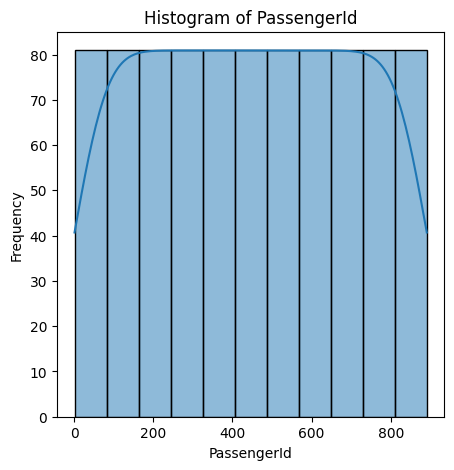

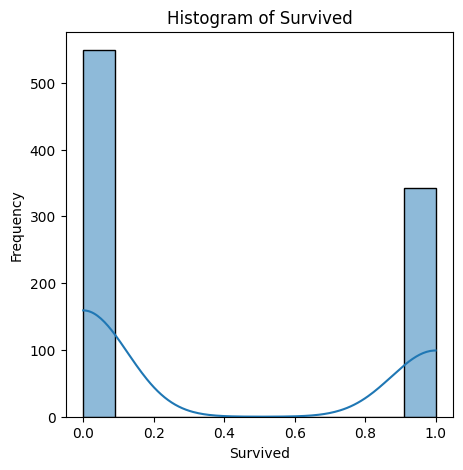

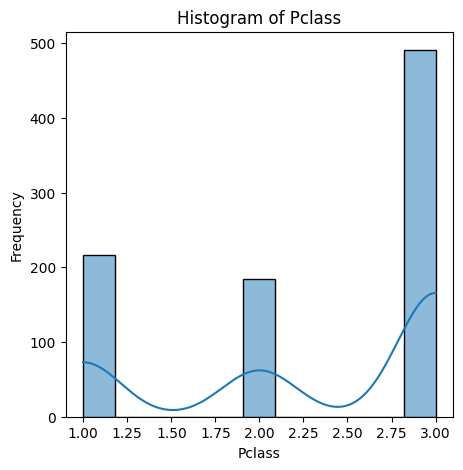

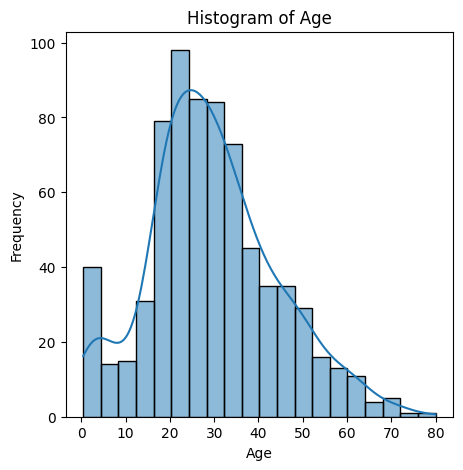

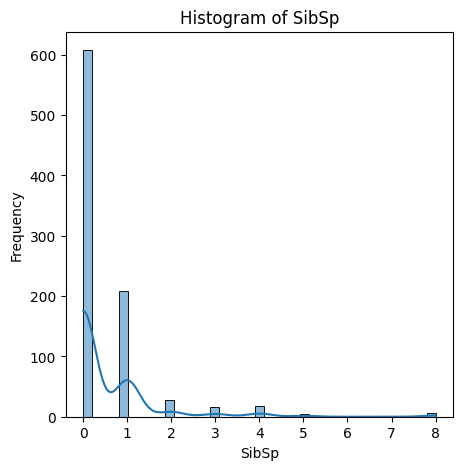

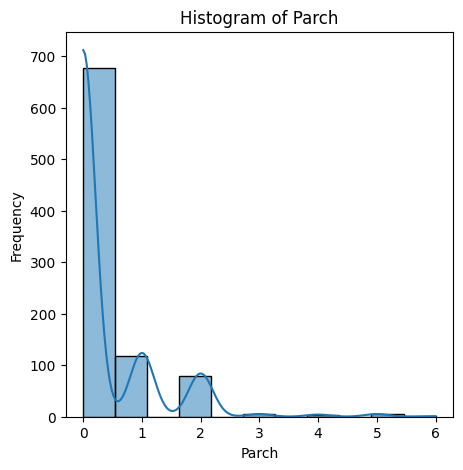

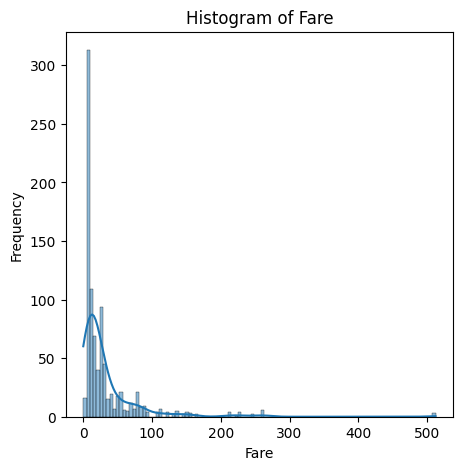

In [38]:
# Get the list of columns in the DataFrame
columns = df_clean.columns
# Check the data type of the column
for column in columns:
    dtype = df[column].dtype
    # If it's a numerical variable, create a histogram
    if dtype =='int64' or dtype == 'float64':
        plt.figure(figsize = (5,5))
        sns.histplot(df[column], kde = True)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
        
    

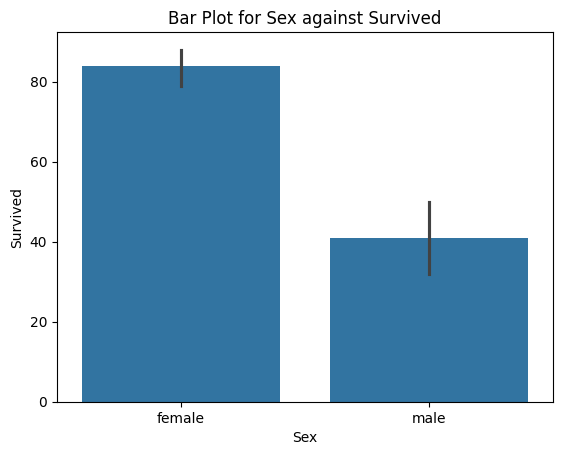

In [40]:
# Create a bar plot with 'Sex' on x-axis and mean of 'Survived' as y-axis
sns.barplot(x=cat_data['Sex'], y=num_data['Survived'], estimator=sum)  
# Set the title
plt.title('Bar Plot for Sex against Survived')
# Show the plot
plt.show()

The graph above illustrates that a majority of males did not survive the Titanic incident.

In [41]:
num_data.skew()

PassengerId   -0.053694
Survived      -0.756705
Pclass         2.701443
Age            0.005570
SibSp          1.458092
Parch          1.535565
Fare           2.729856
dtype: float64

Pclass: A skewness of 2.701443 indicates a significant positive skewness, suggesting that, the distribution is heavily right-skewed. 
This insight could indicate that a large portion of the dataset consists of lower-class passengers, with relatively fewer observations in 
higher-class categories. Understanding this skewness could be crucial for analyzing socioeconomic disparities among passengers.

Age: With a skewness of 0.005570, Age shows a nearly symmetrical distribution. 

SibSp and Parch: Both SibSp and Parch exhibit positive skewness (1.458092 and 1.535565, respectively), indicating right-skewed distributions. 
This suggests that a significant portion of passengers may have travelled with few or no siblings/spouses (SibSp) or parents/children (Parch) aboard
the Titanic.

Fare: With a skewness of 2.729856, Fare demonstrates a significant positive skewness, indicating a heavily right-skewed distribution. 
This insight suggests that a large proportion of passengers paid relatively lower fares, while a smaller subset may have paid substantially higher 
fares.

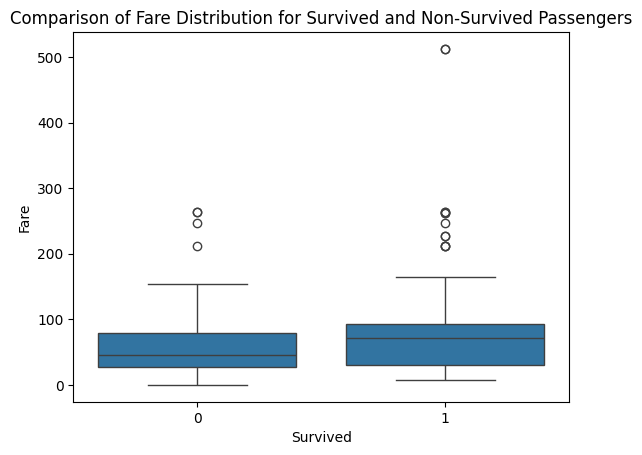

In [48]:
# Create a box plot with 'Survived' on the x-axis and 'Fare' on the y-axis
sns.boxplot(x=num_data['Survived'], y=num_data['Fare'])

# Set labels and title
plt.xlabel('Survived')
plt.ylabel('Fare')
plt.title('Comparison of Fare Distribution for Survived and Non-Survived Passengers')

# Show the plot
plt.show()

The survived(1) median is higher compared to survived(0); This difference in median fares suggests that passengers who paid higher fares (likely from higher passenger classes) had a higher chance of survival. This aligns with the historical accounts that passengers in higher classes 
were given priority during the evacuation process.

In [8]:
# Drop the PassengerId and Name column from the DataFrame
df_clean.drop('PassengerId', axis=1, inplace=True)
df_clean.drop('Name', axis=1, inplace=True)

In [9]:
#Handling Outliers
# nd contains numerical data
num_list = num_data
q1 = num_data.quantile(0.25)
q3 = num_data.quantile(0.75)
iqr = q3-q1
outlier_conditions = (( num_list < (q1 - 1.5 * iqr)) | (num_list > (q3 + 1.5 * iqr)))

# Display rows containing outliers
outliers = df_clean[outlier_conditions.any(axis=1)]
print("Rows with outliers:")
print(outliers)


Rows with outliers:
     Survived  Pclass     Sex   Age  SibSp  Parch             Ticket  \
10          1       3  female   4.0      1      1            PP 9549   
21          1       2    male  34.0      0      0             248698   
27          0       1    male  19.0      3      2              19950   
66          1       2  female  29.0      0      0         C.A. 29395   
75          0       3    male  25.0      0      0             348123   
88          1       1  female  23.0      3      2              19950   
118         0       1    male  24.0      0      1           PC 17558   
123         1       2  female  32.5      0      0              27267   
148         0       2    male  36.5      0      2             230080   
183         1       2    male   1.0      2      1             230136   
193         1       2    male   3.0      1      1             230080   
205         0       3  female   2.0      0      1             347054   
251         0       3  female  29.0      1  

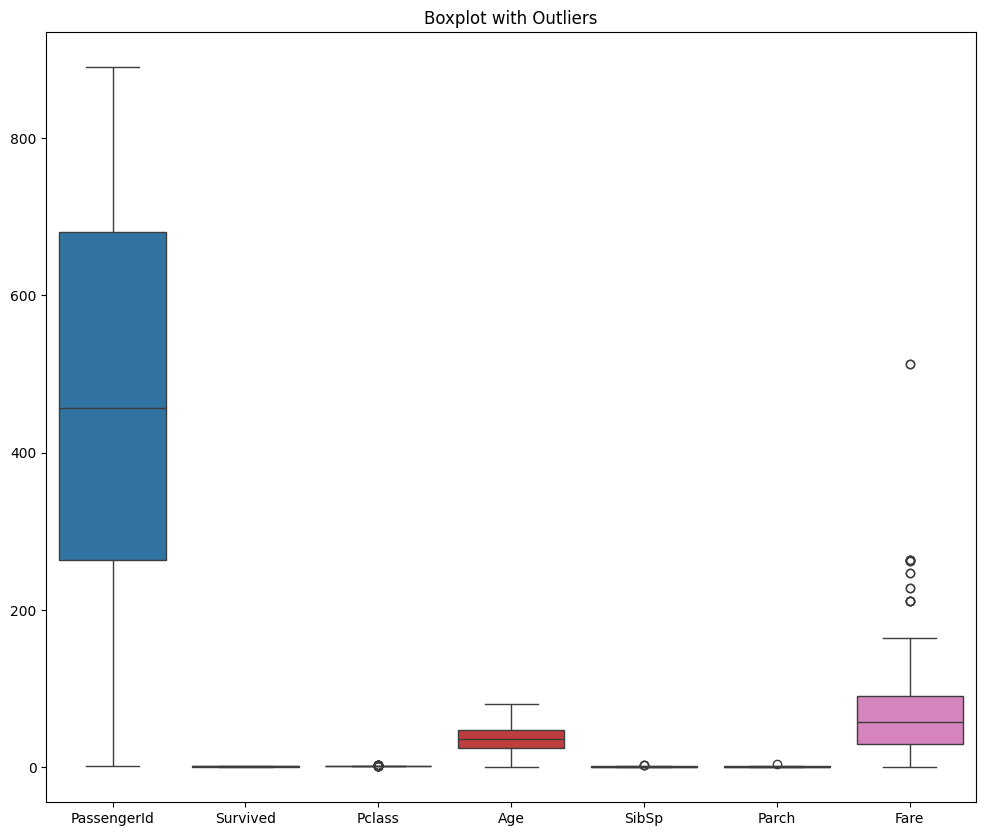

In [54]:
# Visualize the outliers using a boxplot
plt.figure(figsize=(12, 10))  
sns.boxplot(data=num_data)
plt.title("Boxplot with Outliers")
plt.show()

Fare data is raising concerns due to the possible presence of outliers. I will handle this by replacing the observations with the median.

In [58]:
# Calculate the first quartile (Q1), third quartile (Q3), and the interquartile range (IQR) for the 'Fare' column
q1 = df_clean['Fare'].quantile(0.25)
q3 = df_clean['Fare'].quantile(0.75)
iqr = q3 - q1

# Define outlier conditions using the IQR method
outlier_conditions = ((df_clean['Fare'] < (q1 - 1.5 * iqr)) | (df_clean['Fare'] > (q3 + 1.5 * iqr)))

# Calculate the median fare
median_fare = df_clean['Fare'].median()

# Replace fare values that meet outlier conditions with the median fare
df_clean.loc[outlier_conditions, 'Fare'] = median_fare


In [62]:
# Convert object variables to factors (categories)

df_clean['Sex'] = df_clean['Sex'].astype('category')
df_clean['Ticket'] = df_clean['Ticket'].astype('category')
df_clean['Cabin'] = df_clean['Cabin'].astype('category')
df_clean['Embarked'] = df_clean['Embarked'].astype('category')

In [63]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185 entries, 1 to 889
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  185 non-null    int64   
 1   Pclass    185 non-null    int64   
 2   Sex       185 non-null    category
 3   Age       185 non-null    float64 
 4   SibSp     185 non-null    int64   
 5   Parch     185 non-null    int64   
 6   Ticket    185 non-null    category
 7   Fare      185 non-null    float64 
 8   Cabin     185 non-null    category
 9   Embarked  185 non-null    category
dtypes: category(4), float64(2), int64(4)
memory usage: 25.7 KB


In [11]:
# Spliting Data for modelling
random_state=42
# Drop the target variable 'Survived' from the features
X = df_clean.drop('Survived', axis=1)

# Target variable
y = df_clean['Survived']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, columns=['Sex', 'Ticket', 'Cabin', 'Embarked'], drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=random_state)


In [12]:
print("\nSample of X_train:")
print(X_train[:5])  # Print the first 5 rows of X_train

print("\nSample of X_test:")
print(X_test[:5])  # Print the first 5 rows of X_test

print("\nSample of y_train:")
print(y_train[:5])  # Print the first 5 elements of y_train

print("\nSample of y_test:")
print(y_test[:5])  # Print the first 5 elements of y_test


Sample of X_train:
[[-0.3699615  -1.26810746 -0.71710172 ... -0.07372098 -0.10454167
  -1.32709986]
 [-0.3699615   0.13881905 -0.71710172 ... -0.07372098 -0.10454167
   0.7535228 ]
 [ 1.58554927 -2.22737553  2.40439988 ... -0.07372098 -0.10454167
   0.7535228 ]
 [ 1.58554927 -0.43674179 -0.71710172 ... -0.07372098 -0.10454167
   0.7535228 ]
 [-0.3699615   0.52252628  2.40439988 ... -0.07372098  9.56556323
  -1.32709986]]

Sample of X_test:
[[-0.3699615   0.7143799  -0.71710172 ... -0.07372098 -0.10454167
   0.7535228 ]
 [-0.3699615   0.07486785  0.84364908 ... -0.07372098 -0.10454167
   0.7535228 ]
 [-0.3699615  -0.94835143  2.40439988 ... -0.07372098 -0.10454167
  -1.32709986]
 [-0.3699615   0.01091664 -0.71710172 ... -0.07372098 -0.10454167
   0.7535228 ]
 [-0.3699615   0.7783311   0.84364908 ... -0.07372098 -0.10454167
   0.7535228 ]]

Sample of y_train:
329    1
332    0
183    1
66     1
245    0
Name: Survived, dtype: int64

Sample of y_test:
110    0
248    1
742    1
540    1


In [13]:
# Checking for imbalance in the datasets.)
y.value_counts()

Survived
1    125
0     60
Name: count, dtype: int64

In [20]:
# Initialize SMOTE ( to address the class imbalance in the datasets.)
sm = SMOTE()

In [21]:
# The implementation of the fit_resample 
X,y = sm.fit_resample(X,y)

In [22]:
# Create a DataFrame to see the distribution of classes in the target vector y
data = pd.concat([X, y], axis=1)
class_distribution = data[y.name].value_counts()

print(class_distribution)

Survived
1    125
0    125
Name: count, dtype: int64


In [16]:
y.value_counts()

Survived
1    125
0    125
Name: count, dtype: int64

In [25]:
# Set the random seed
np.random.seed(42)

# Initialize classifiers
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()

# Train and evaluate each classifier
classifiers = [random_forest, gradient_boosting]

for clf in classifiers:
    # Train the classifier
    clf.fit(X_train, y_train)

    # For RandomForestClassifier, print feature importances
    if isinstance(clf, RandomForestClassifier):
        feature_names = X.columns  
        print("RandomForestClassifier Feature Importances:", feature_names)

    # Making predictions on the test set
    y_pred = clf.predict(X_test)
    
    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Print the results
    print(f"Classifier: {clf.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)
    print("="*50)


RandomForestClassifier Feature Importances: Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_male', 'Ticket_110413',
       'Ticket_110465', 'Ticket_110564', 'Ticket_110813',
       ...
       'Cabin_E8', 'Cabin_F G63', 'Cabin_F G73', 'Cabin_F2', 'Cabin_F33',
       'Cabin_F4', 'Cabin_G6', 'Cabin_T', 'Embarked_Q', 'Embarked_S'],
      dtype='object', length=268)
Classifier: RandomForestClassifier
Accuracy: 0.7027
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.33      0.48        15
           1       0.68      0.95      0.79        22

    accuracy                           0.70        37
   macro avg       0.76      0.64      0.63        37
weighted avg       0.74      0.70      0.66        37

Classifier: GradientBoostingClassifier
Accuracy: 0.8108
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.83      0.86    

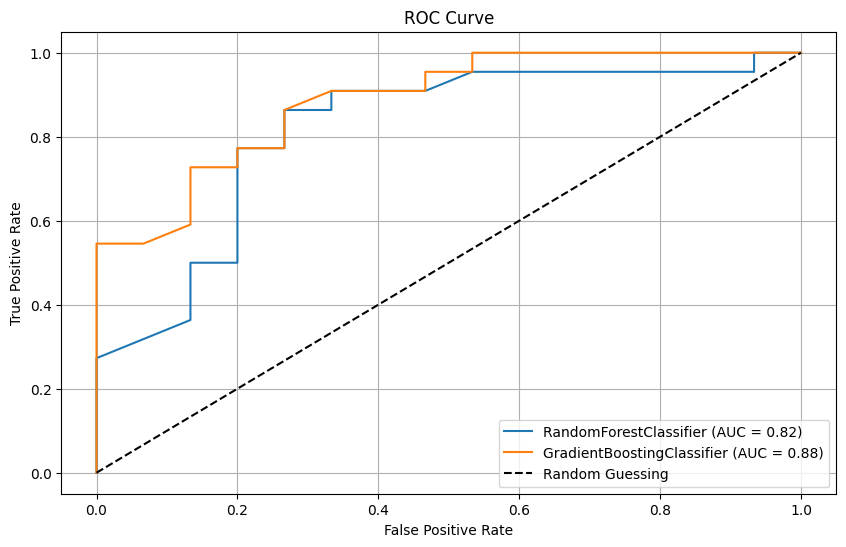

In [26]:

# Set the random seed
np.random.seed(42)

# Initialize classifiers
random_forest = RandomForestClassifier()
gradient_boosting = GradientBoostingClassifier()

# Train and evaluate each classifier
classifiers = [random_forest, gradient_boosting]

plt.figure(figsize=(10, 6))

for clf in classifiers:
    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict_proba(X_test)[:, 1]  # Predict probabilities for positive class

    # Compute ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{clf.__class__.__name__} (AUC = {auc_score:.2f})')

# Plot ROC curve for random guessing
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


Feature Importance: The feature importance scores from the RandomForestClassifier offer insights into which features are most influential in predicting survival. For example, the importance of features like Pclass, Age, SibSp, Parch, Fare, Sex_male, Ticket_110413, 'Ticket_11046',and 'Ticket_11056' suggests that these factors strongly influence
the model's predictions. This aligns with common knowledge and historical data showing that factors like gender, fare, and age were significant
determinants of survival on the Titanic.

Model Performance: The accuracy of both classifiers on the test set indicates their overall effectiveness in making predictions. 
The RandomForestClassifier achieved an accuracy of 70.27%, while the GradientBoostingClassifier achieved a higher accuracy of 81.08%. 
This suggests that the Gradient Boosting model may be better suited for this particular dataset, as it achieved higher overall accuracy.

In [29]:
from sklearn.metrics import accuracy_score
import joblib

# Set the random seed
np.random.seed(42)

# Define hyperparameters grid for Random Forest Classifier
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define hyperparameters grid for Gradient Boosting Classifier
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Define classifiers with hyperparameter grids
random_forest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Perform Grid Search with k-fold cross-validation for each classifier
classifiers = [
    ('Random Forest', random_forest, rf_param_grid),
    ('Gradient Boosting', gradient_boosting, gb_param_grid)
]

# Define the number of folds for cross-validation
num_folds = 5

# Results dictionary to store predictions and accuracies
predictions = {}
test_accuracies = {}

for name, clf, param_grid in classifiers:
    # Initialize KFold object
    kf = KFold(n_splits=num_folds)
    
    grid_search = GridSearchCV(clf, param_grid, cv=kf, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameters and mean cross-validation score
    print(f"Best hyperparameters for {name}: {grid_search.best_params_}")
    print(f"Mean Cross-validation Score for {name}: {grid_search.best_score_:.4f}")
    
    # Train the classifier on the entire training set with best hyperparameters
    best_clf = grid_search.best_estimator_
    best_clf.fit(X_train, y_train)
    
    # Save the trained model
    joblib.dump(best_clf, f'{name}_model.joblib')
    
    # Make predictions on the test set
    y_pred = best_clf.predict(X_test)
    
    # Calculate accuracy on the test set
    test_accuracy = accuracy_score(y_test, y_pred)
    
    # Store predictions and test accuracy in the results dictionaries
    predictions[name] = y_pred
    test_accuracies[name] = test_accuracy

    print(f"Accuracy on Test Set for {name}: {test_accuracy:.4f}")
    print("="*50)


Best hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Cross-validation Score for Random Forest: 0.7444
Accuracy on Test Set for Random Forest: 0.7297
Best hyperparameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Mean Cross-validation Score for Gradient Boosting: 0.7710
Accuracy on Test Set for Gradient Boosting: 0.7568


In [ ]:
In conclusion, this study prefers the K-fold Gradient Boosting model with a mean cross-validation score of 0.7710 due to its strong generalization
capabilities and robustness across various scenarios. This model effectively handles variations in data distribution, noise, and unforeseen patterns
without significant performance degradation, making it well-suited for real-world applications where data conditions may vary. Additionally, 
prioritizing generalization promotes ethical and fair decision-making by mitigating the risk of model discrimination or bias towards specific 
groups or individuals. Models that generalize well are less prone to relying on spurious correlations within the training data, thereby fostering 
more equitable outcomes across diverse populations.